# Cure My Leaf

Sometimes the plants that can have our crops can be affected by external factors or our environment, the leaves of the plants can be infected with certain bacteria that make them die faster.
The `CureMyLeaf` is a convolutional neural network model to predict if a leaf of your crop has a Bean, Angular bacteria or if it is simply healthy.

## Description of the problem

We will use the Api for download the data and convert to a data frame in the format parquet to control all of data

In [2]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/AI-Lab-Makerere/beans/" + splits["train"])

df.head(5)

,image_file_path,image,labels
0,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


The dataset have 3 types of leafs

2 for the healthy leafs

0 for the angular leafs (No healty)

1 for the royal leafs (No healty)

In [3]:
df['labels'].value_counts()

labels
1    348
0    345
2    341
Name: count, dtype: int64

As the dataset stands, the data is of little use for training the neural network model. We will convert the column 'image', which uses byte encoding, into a numerical array of the color characters (RGB)

## Convert column image to a color numeric array.

In [4]:
from PIL import Image
import io
import pandas as pd
import numpy as np

# Function to convert bytes to a numeric array
def decode_image_bytes_colors(image_dict):
    image_bytes = image_dict['bytes']
    return np.array(Image.open(io.BytesIO(image_bytes))) / 255.0  #Normalize the values between 0 and 1 

df['colors_array'] = df['image'].apply(decode_image_bytes_colors)


df=df[['image_file_path','colors_array','labels']]

df.head(20)

,image_file_path,colors_array,labels
0,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.2196078431372549, 0.14901960784313725, 0....",0
1,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.23529411764705882, 0.4117647058823529, 0....",0
2,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.6235294117647059, 0.4980392156862745, 0.4...",0
3,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.33725490196078434, 0.3411764705882353, 0....",0
4,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.28627450980392155, 0.3137254901960784, 0....",0
5,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.20784313725490197, 0.1607843137254902, 0....",0
6,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.1450980392156863, 0.12156862745098039, 0....",0
7,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.5098039215686274, 0.5568627450980392, 0.2...",0
8,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.4549019607843137, 0.34509803921568627, 0....",0
9,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.33725490196078434, 0.48627450980392156, 0...",0


**Check the dimensions of the images in the dataset**


In [5]:
def get_image_dimensions_column(column:str):
    image_dimensions = df[column].apply(lambda x: str(x.shape))
    return image_dimensions.value_counts()

image_dimensions_counts = get_image_dimensions_column('colors_array')
print(image_dimensions_counts)

colors_array
(500, 500, 3)    1034
Name: count, dtype: int64


## Resizing the images to 224ppx

**In this case, it is better to change the dimensions of the images, why? Simply because it is easier for the model to train on the data if they have the same dimensions, and some pre-trained models have the limitation that they can only use certain dimensions.**

In [6]:

def resize_image(image_array, size=(224, 224)):
    image = Image.fromarray((image_array * 255).astype(np.uint8))  
    resized_image = image.resize(size)  
    return np.array(resized_image) / 255.0  

df['resized_colors_array'] = df['colors_array'].apply(resize_image)



In [7]:
get_image_dimensions_column('resized_colors_array')

df.drop(axis=1,columns='colors_array',inplace=True)

In [8]:
df=df[['image_file_path','resized_colors_array','labels']]

df.head(5)

,image_file_path,resized_colors_array,labels
0,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.21568627450980393, 0.1450980392156863, 0....",0
1,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.23529411764705882, 0.40784313725490196, 0...",0
2,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.6431372549019608, 0.5098039215686274, 0.4...",0
3,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.29411764705882354, 0.2980392156862745, 0....",0
4,/home/albert/.cache/huggingface/datasets/downl...,"[[[0.27450980392156865, 0.3137254901960784, 0....",0


In [9]:
from sklearn.model_selection import train_test_split

X=np.stack(df['resized_colors_array'].values)

Y=df['labels'].values

print(X.shape) #Now we have a array with 1034 data, the images have 224px of lenght,224 width and three color channels

x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.30,stratify=Y)

(1034, 224, 224, 3)


**Separating the date in variables for train the model and test it**

**The proporcion is `70%` of the the for train the model and `30%` for testing**

## Create the neural network using tensorflow

`Activation function `
$$
\text{ReLU}(x) = \max(0, x)
$$


`Selection function`
$$
\text{Softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} \quad 
$$


`Neural Network structure`

$$\text{VGG16 Visual Geometry Group 16 } $$


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Three classes: Healthy, Angular, Bean
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [17]:
model.fit(x_train, y_train, epochs=35, validation_data=(x_test, y_test))


Epoch 1/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8049 - loss: 0.5167 - val_accuracy: 0.8006 - val_loss: 0.4452
Epoch 2/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8363 - loss: 0.4480 - val_accuracy: 0.8135 - val_loss: 0.4491
Epoch 3/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8027 - loss: 0.5199 - val_accuracy: 0.8135 - val_loss: 0.4335
Epoch 4/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8149 - loss: 0.4660 - val_accuracy: 0.8006 - val_loss: 0.4343
Epoch 5/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8069 - loss: 0.4756 - val_accuracy: 0.8360 - val_loss: 0.4022
Epoch 6/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8198 - loss: 0.4834 - val_accuracy: 0.8585 - val_loss: 0.4054
Epoch 7/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.7924 - loss: 0.5173 - val_accuracy: 0.8232 - val_loss: 0.4145
Epoch 8/35
23/23 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8299 - loss: 0.4502 - val_accuracy: 0.8521 - val_loss:

In [19]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Precision for the test data: {accuracy * 100:.2f}%')


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8487 - loss: 0.3638
Precision for the test data: 87.14%


## Accurancy 87.14 %

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


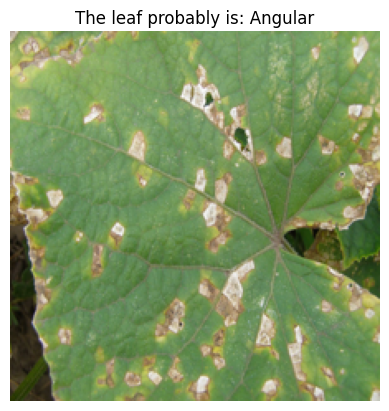

In [59]:
import matplotlib.pyplot as plt

def image_prediction(image_array, true_label=None):
    plt.imshow(image_array)
    plt.axis('off')
    
    
    image_expanded = np.expand_dims(image_array, axis=0) #Predict the class
    prediction = model.predict(image_expanded)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    label_mapping = {2: "Healthty", 1: "Beans", 0: "Angular"}
    predicted_label = label_mapping[predicted_class]
    
    #Show the label
    if true_label is not None:
        true_label_name = label_mapping[true_label]
        title = f'Label real: {true_label_name}\nThe leaf probably is : {predicted_label}'
    else:
        title = f'The leaf probably is: {predicted_label}'
    
    plt.title(title)
    plt.show()


def load_and_preprocess_image(image_path):

    image = Image.open(image_path).convert('RGB')  # Ensure image is RGB

    image = image.resize((224, 224))

    image_array = np.array(image) / 255.0

    return image_array

# Test with some internet image healthty

image_route='WebImagesTest\AngularLeaf.jpeg'

new_image = load_and_preprocess_image(image_route)


image_prediction(new_image)



## Try yourself

In [ ]:
import pyfiglet

def title():
    ascii_art = pyfiglet.figlet_format("CureMyLeaf")
    return ascii_art


def user_try():
    
    print(title())
    
    print('Welcome to CureMyLeaf \n\nPlease enter the relative path of your image:')

    image_path = input()  

    image = load_and_preprocess_image(image_path)  

    prediction = image_prediction(image)  

    print(f"Prediction: {prediction}")  


user_try()